# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('_unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


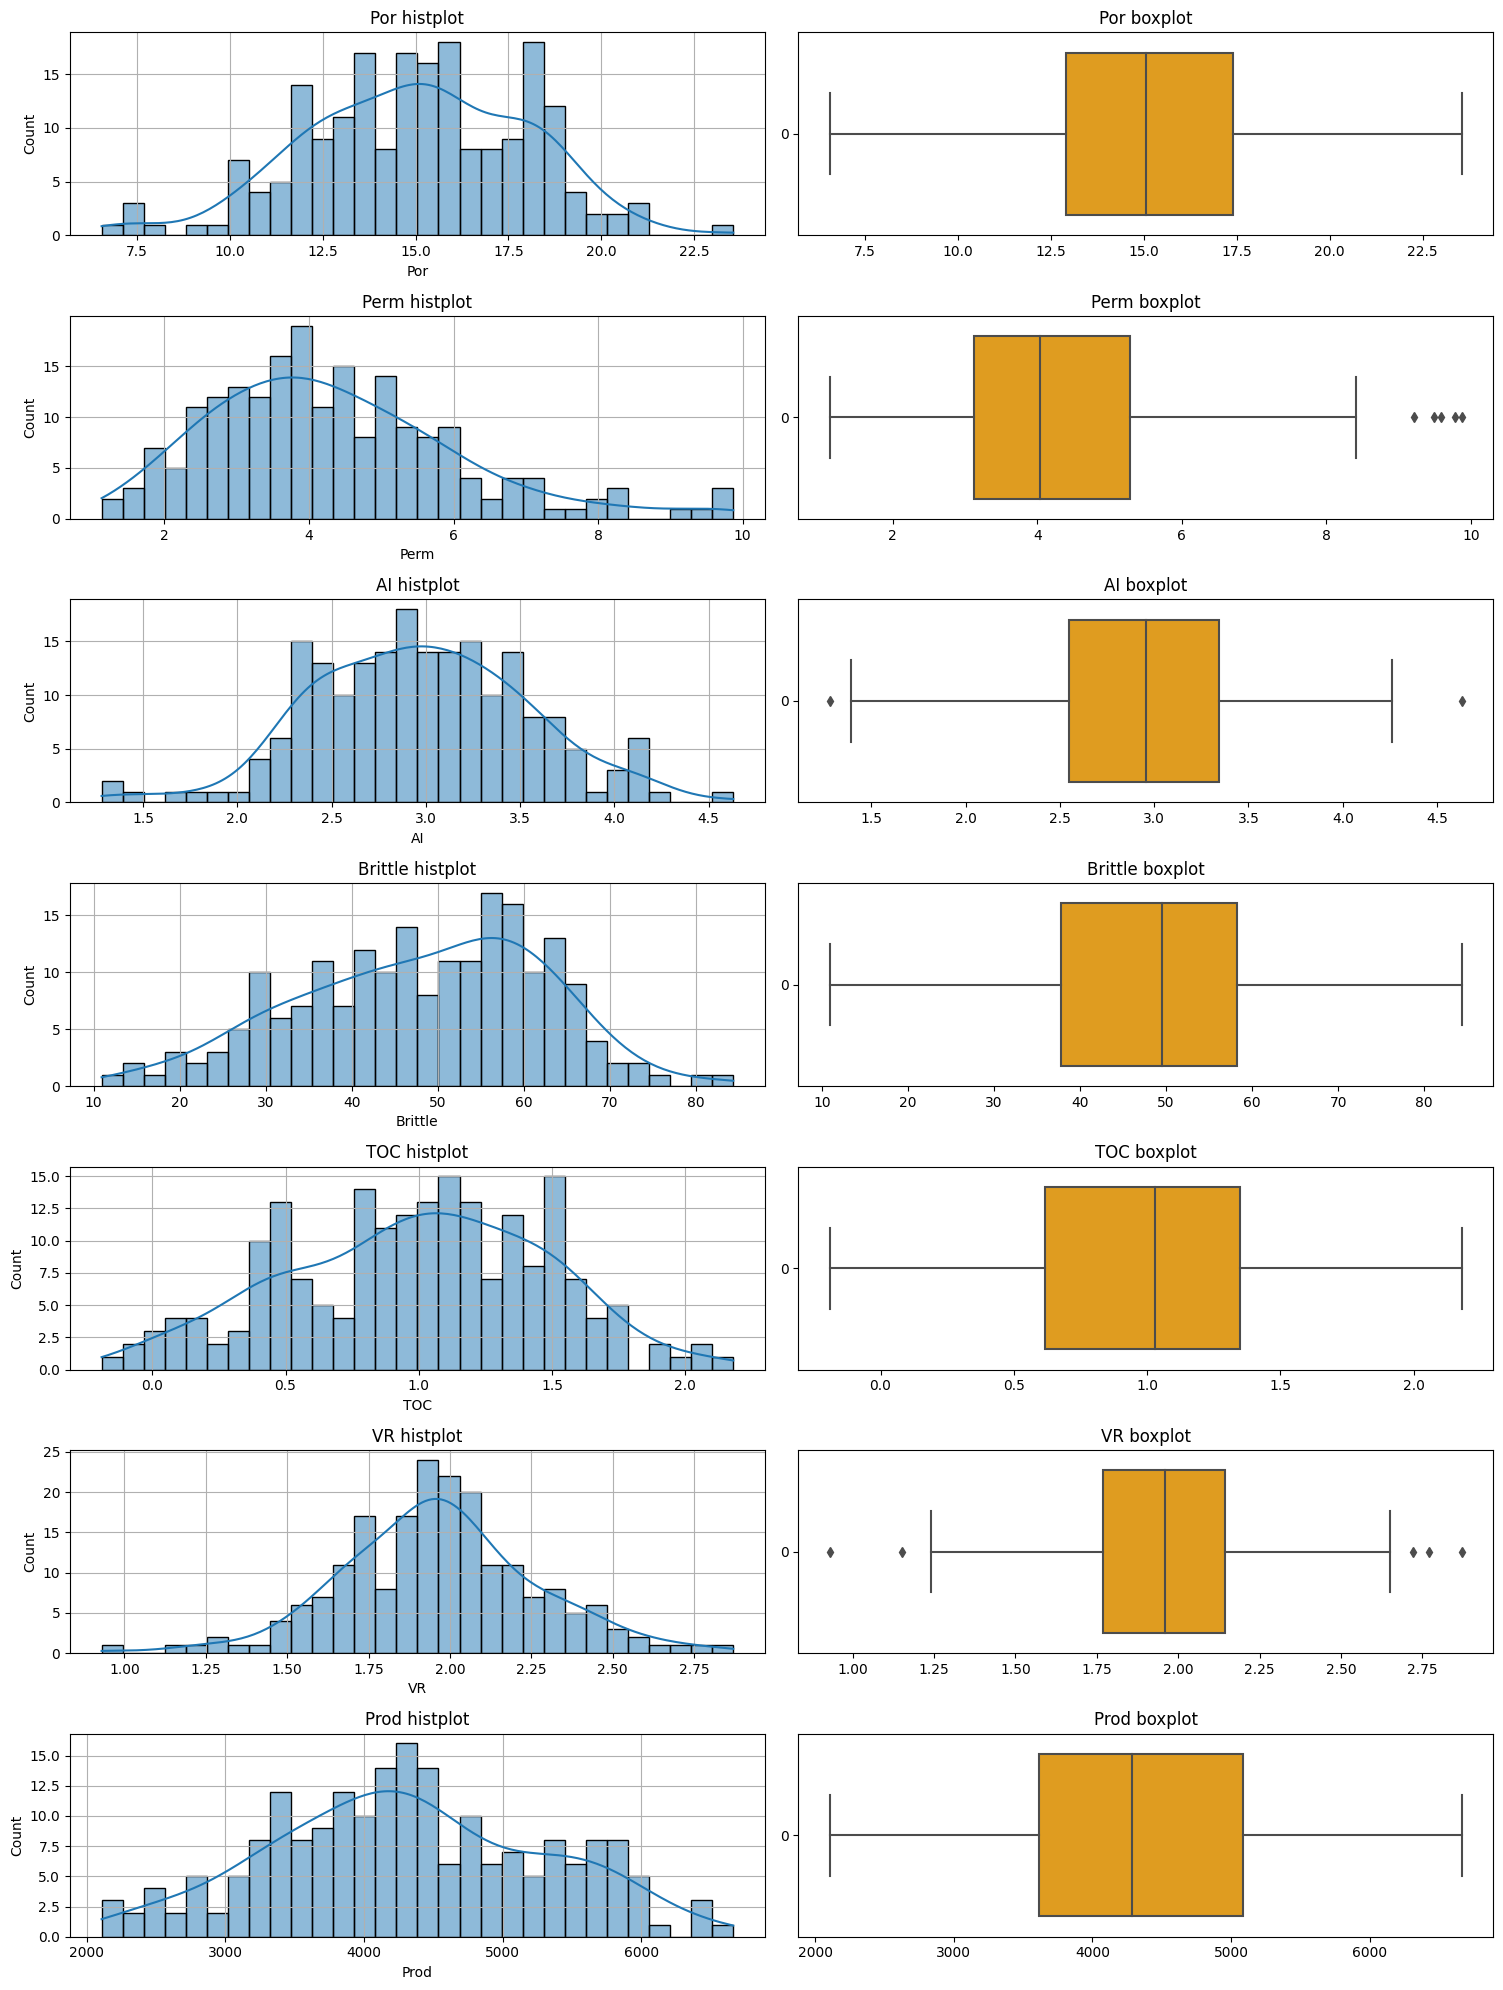

In [3]:
display(data.info())
display(data.describe())

# исключаем признак Well, поскольку он содержит только номер скважины
types = data.dtypes
num_features = list(types[(types != 'int64')].index)

n = len(num_features)
# фигура + n х 2 координатных плоскостей
fig, axes = plt.subplots(n, 2, figsize=(15, 20))

# i- индекс, feature - название признака в таблице
for i, feature in enumerate(num_features):
    # Строим гистограмму распределения признака
    histplot = sns.histplot(data=data[feature], bins=30, ax=axes[i][0], kde=True)
    histplot.set_title('{} histplot'.format(feature))
    histplot.grid()

    # Строим диаграмму размаха
    boxplot = sns.boxplot(data=data[feature], orient='h', palette=['orange', 'blue'], ax=axes[i][1])
    boxplot.set_title('{} boxplot'.format(feature));

# выравнивание графиков
plt.tight_layout()


### Выводы
* Наблюдаются единичные выброс в признаках Perm, Al, VR
* Распределение всех признаков близко к нормальному, поэтому можем использовать корреляцию Пирсона
* Признак Well лучше удалить, поскольку он является просто индексом - номер скважины в списке
* Признаки придется нормализировать

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Матрица корреляции:


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


Ранг матрицы: 8
Определитель матрицы: 0.0007299388072652082


<Axes: >

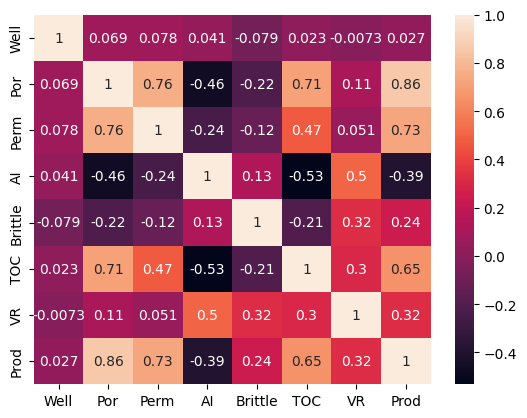

In [4]:
corr_table = data.corr()

print("Матрица корреляции:")
display(corr_table)
print("Ранг матрицы:", np.linalg.matrix_rank(corr_table))
print("Определитель матрицы:", np.linalg.det(corr_table))

sns.heatmap(data=corr_table, annot=True)


<Axes: >

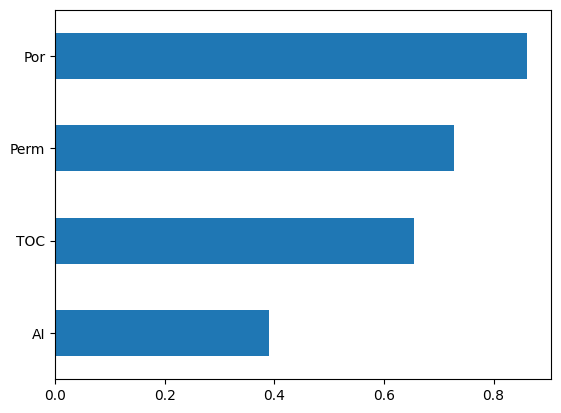

In [5]:
# топ признаков, коррелирующих с целевой переменной
corr_table['Prod'].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()

### Выводы
* признаки `Por` (пористость скважины, 0.86) и `Perm` (проницаемость скважины, 0.73) сильно коррелируют с целевой переменной
* есть средняя корреляция между признаком `TOC` (общий органический углерод, 0.65) и целевой переменной
* корреляционная матрица плохо обусловлена - определитель матрицы очень близок у нулю (det(corr_matrix) = 0.0007)
* мультиколлинеарности не наблюдается - нет очень сильной корреляции между признаками (хотя есть сильная корреляция между признаками `Por` и `Perm` и между признаками `Por` и `TOC`)
* поскольку у нас есть признаки, показывающие линейную зависимость с целевой переменной, и не наблюдается мультиколлинеарности, то можно использовать модель классической линейной регрессии по методу наименьших квадратов

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [6]:
# создаем матрицу наблюдений с единичным столбцом
X = np.column_stack((np.ones(data.shape[0]), data.drop(['Prod'], axis=1)))
y = data['Prod']

# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T @ X) @ X.T @ y
w_hat_rounded = np.round(w_hat).astype('int')

print("Коэффициенты модели:", w_hat_rounded)

Коэффициенты модели: [-1232     0   230   116  -365    25   -78   785]


Получаем следующие коэффициенты (округленные до целого):
* $\widehat{w}_0 = -1232$
* $\widehat{w}_{Well} = 0$
* $\widehat{w}_{Por} = 230$
* $\widehat{w}_{Perm} = 116$
* $\widehat{w}_{AI} = -365$
* $\widehat{w}_{Brittle} = 25$
* $\widehat{w}_{TOC} = -78$
* $\widehat{w}_{VR} = 785$

### Выводы
* признак `Well` (идентификатор скважины) с уникальными значениями является (как и предсказано выше) неинформативным, то есть не оказывающий никакого влияния на целевую переменную
* если пористость скважины (наиболее коррелирующий с целевой переменной признак `Por`) изменится на 1%, то добыча газа в сутки (целевой признак `Prod`) увеличится на 230 млн. кубических футов
* если акустический импеданс (признак `AI`) увеличится на 1 млн $кг/м^2$, то добыча гоаза в сутки уменьшится на 365 млн. кубических футов
* интересен признак `VR` (коэффициент отражения витринита), влияющий больше всего на добычу газа судя по коэффициентам, но имеющий слабую связь (коэффициент корреляции - 0.32) с целевым признаком. Причем, эта связь статистически значима (см. следующий блок кода). То есть, если в двух осадочных бассейнах коэффициент отражения витринита отличается на 1%, но добыча газа в сутки будет отличаться на 785 млн. кубических футов.

In [7]:
from scipy import stats

# H0 - нет статистически значимой корреляции между признакаи VR и Prod
# H1 - между переменными VR и Prod существует статистически значимая корреляция
correlation_coefficient, p_value = stats.pearsonr(data['VR'], data['Prod'])
print(f'Коэффициент корреляции: {correlation_coefficient}')
print(f'P-значение: {p_value:.4f}')

alpha = 0.05
if p_value < alpha:
    print('Корреляция статистически значима (отвергаем H0)')
else:
    print('Корреляция не статистически значима (не отвергаем H0)')

Коэффициент корреляции: 0.32318154748131245
P-значение: 0.0000
Корреляция статистически значима (отвергаем H0)


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [8]:
from sklearn import metrics

# a) Постройте прогноз выработки газа для скважины со следующими параметрами:
y_new = 4748.315024
x_new = pd.DataFrame.from_dict({
    0: 1,
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42,
 }, orient='index').T.values[0]

y_new_pred = x_new @ w_hat
print('MAE для новой скважины: {:.0f}'.format(abs(y_new - y_new_pred).round()))
print('MAPE для новой скважины: {:.3f}'.format(metrics.mean_absolute_percentage_error([y_new], [y_new_pred]) * 100))

# б) Постройте прогноз выработки газа для всех скважин из обучающего набора данных.
y_pred = []
for x_row in X:
    y_pred.append(x_row @ w_hat_rounded)

print('MAPE для всех скважин: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred)*100))
print('R^2 для всех скважин: {:.3f}'.format(metrics.r2_score(y, y_pred)))

MAE для новой скважины: 25
MAPE для новой скважины: 0.532
MAPE для всех скважин: 3.648
R^2 для всех скважин: 0.960


### Выводы
* Абсолютная ошибка для новой скважины - 25 млн. кубических футов, что составляет ошибку в пол процента. Скорее всего, специалист из газодобывающей отрасли смог бы дать ответ, на сколько хороша модель. Но мне кажется, что пол процента - это отличный результат.
* Что касается средней абсолютной ошибки в 3.65% (и метрики $R^2 = 0.96$) на всех скважинах, я не был бы столь оптиместичным, поскольку мы сделали предсказания на тех же данных, на которых была натренирована модель. Необходимо получить тестовые данные для проверки качества модели.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

Продублируем коэффициенты модели:
* $\widehat{w}_0 = -1232$
* $\widehat{w}_{Well} = 0$
* $\widehat{w}_{Por} = 230$
* $\widehat{w}_{Perm} = 116$
* $\widehat{w}_{AI} = -365$
* $\widehat{w}_{Brittle} = 25$
* $\widehat{w}_{TOC} = -78$
* $\widehat{w}_{VR} = 785$

и матрицу коррелиций:

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


Найдено несоответствие в столбце: TOC
 -- коэффициент корреляции: 0.6544451995719837
 -- коэффициент модели: -78


<Axes: xlabel='TOC', ylabel='Prod'>

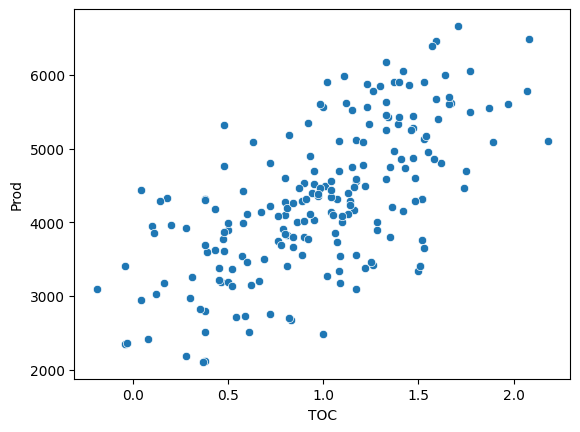

In [9]:
display(corr_table)

corr_values = corr_table['Prod'].values
w_values = w_hat_rounded[1:]

for i in range(0, len(w_values)):
    if (
        corr_values[i] < 0 and w_values[i] > 0
        or corr_values[i] > 0 and w_values[i] < 0
    ):
        print('Найдено несоответствие в столбце:', corr_table.columns[i])
        print(f' -- коэффициент корреляции: {corr_values[i]}')
        print(f' -- коэффициент модели: {w_values[i]}')

sns.scatterplot(x='TOC', y='Prod', data=data)

### Выводы
* фактор `TOC` со значением -78 (процентом органического углерода) в модели линейной регрессии противоречит соответствующему коэффициенту корреляции со значением 0.65. Модель говорит, что зависимость обратная, в то время как коэффициент корреляции (и график выше) - прямая.
* не могу точно сказать, почему произошло такое несоответствие. Если бы у нас была очень сильная связь между признаком `TOC` и другим фактором (при коэффициенте корреляции хотя бы в `0.8` и выше), то можно было бы утверждать, что причина в мультиколлинеарности признаков. Возможно есть частичная мультиколлинеарность или нелинейная зависимость признака `TOC` от других факторов.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

<Axes: >

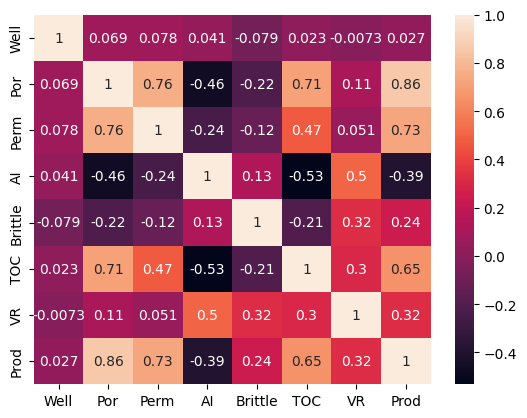

In [10]:
# продублируем матрицу корреляции для исключения сильно коррелирующих факторов, а также факторов, слабо коррелириющих с целевой переменной
sns.heatmap(data=corr_table, annot=True)

Следующие пары факторов сильно коррелируют (значение выше `0.7`):
* `Por` - `Perm`
* `Por` - `TOC`

Отсортируем факторы в порядке убывания коэффициента корреляции с целевой переменной, чтобы оставить те факторы, которые коррелируются больше с целевой переменной, а также исключить факторы со значением меньше `0.05`:

 type: <class 'matplotlib.container.BarContainer'>


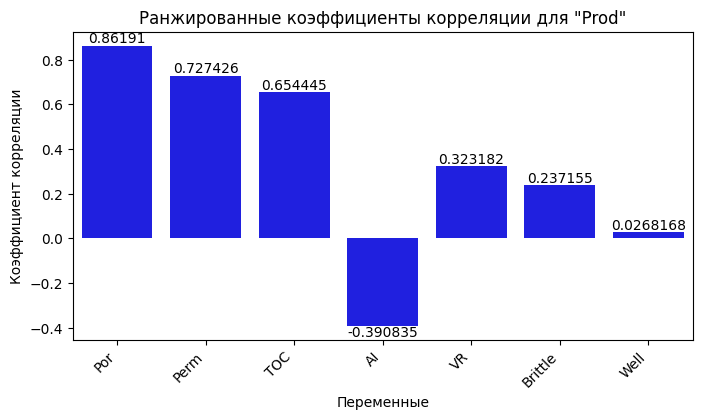

In [11]:
# Данные для построения диаграммы
data_bar = corr_table['Prod'].drop('Prod')
variable_names = list(data_bar.index)
correlation_values = data_bar

# Сортировка по абсолютному значению коэффициентов корреляции
sorted_indices = sorted(range(len(correlation_values)), key=lambda k: abs(correlation_values[k]), reverse=True)
sorted_variable_names = [variable_names[i] for i in sorted_indices]
sorted_correlation_values = [correlation_values[i] for i in sorted_indices]

# # Построение столбчатой диаграммы
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=sorted_variable_names, y=sorted_correlation_values, color='blue')
plt.xlabel('Переменные')
plt.ylabel('Коэффициент корреляции')
plt.title('Ранжированные коэффициенты корреляции для "Prod"')
plt.xticks(rotation=45, ha='right')

for i in ax.containers:
    ax.bar_label(i,)
    print(f" type: {type(i)}")

plt.show()

Как видно из диаграммы, признак `Por` лучше всего коррелирует с целевой переменной, поэтому `Perm` и `TOC` исключаем.
Также исключаем признак `Well` из-за слабой корреляции с целевой переменной.

In [12]:
# создаем матрицу наблюдений с единичным столбцом
new_data = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
X = np.column_stack((np.ones(data.shape[0]), new_data))
y = data['Prod']

# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X.T @ X) @ X.T @ y
w_hat_rounded = np.round(w_hat).astype('int')

print(new_data.head(1))
print("Коэффициенты модели:", w_hat_rounded)

y_pred = []
for x_row in X:
    y_pred.append(x_row @ w_hat)

print('MAPE для всех скважин: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred)*100))
print('R^2 для всех скважин: {:.3f}'.format(metrics.r2_score(y, y_pred)))

     Por   AI  Brittle    VR
0  12.08  2.8     81.4  2.31
Коэффициенты модели: [-1835   293  -200    28   517]
MAPE для всех скважин: 4.044
R^2 для всех скважин: 0.945


Получены следующие коэффициенты модели:
* $\widehat{w}_0 = -1835$
* $\widehat{w}_{Por} = 293 \space (старое \space значение: 230)$
* $\widehat{w}_{AI} = -200 \space (старое \space значение: -365)$
* $\widehat{w}_{Brittle} = 28 \space (старое \space значение: 25)$
* $\widehat{w}_{VR} = 517 \space (старое \space значение: 785)$

### Выводы:
* Усилилось влияние коэффициента $\widehat{w}_{Por}$, у которого корреляция с целевой переменной сильная: при увеличении пористость скважины (`Por`) на 1%, добыча газа уже увеличивается на 293 млн. кубических футов (а не на 230)
* Уменьшилось влияние коэффициентов $\widehat{w}_{AI}$, $\widehat{w}_{Brittle}$ и $\widehat{w}_{VR}$, хотя для последнего признака влияние остается высоким не смотря на слабую связь с целевой переменной
* Новые коэффициенты модели соответствуют по знакам коэффициентам корреляции (точнее, мы просто исключили проблемный признак `TOC`, у которого были проблемы с этим, а оставшиеся признаки продолжают соответствовать коэффициентам корреляции)
* Метрики ухудшились, хотя и остаются на приемлемо уровне (но, опять же, необходимы тестовые данне для проверки модели):
  * MAPE: 4.044 (старое значение - 3.648)
  * $R^2: 0.945$ (старое значение - 0.96)


### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
print('Коэффициенты модели:')
for index in range(0, len(new_data.columns)):
    print(f' {new_data.columns[index]}: {round(lr.coef_[index+1])}')
print('MAPE для всех скважин: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred)*100))
print('R^2 для всех скважин: {:.3f}'.format(metrics.r2_score(y, y_pred)))


Коэффициенты модели:
 Por: 293
 AI: -200
 Brittle: 28
 VR: 517
MAPE для всех скважин: 4.044
R^2 для всех скважин: 0.945


### Выводы
* Результаты работы алгоритма из библотеки `sklern` полностью совпали с результатами, полученные вручную: это касается и коэффициентов модели, и оценки метрик.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [14]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [15]:
X = data.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
y = data['Prod']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X_scaled)
print(f'Количество факторов: {X_scaled_poly.shape[1]}')

# оцениваем качество модели на кросс-валидации, метрики — R2, MAPE
cv_results = cross_validate(
    estimator=LinearRegression(),
    X=X_scaled_poly,
    y=y,
    scoring=('r2', 'neg_mean_absolute_percentage_error'),
    cv=5,
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100))
print('R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_r2'].mean()))
print('R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_r2'].mean()))


Количество факторов: 34
MAPE на тренировочных фолдах: 1.773 %
MAPE на валидационных фолдах: 2.681 %
R2 на тренировочных фолдах: 0.990
R2 на валидационных фолдах: 0.975


### Вывод
* при использовании полиномиальных признаков третьего порядка среднее значение следующих метрик на тренировочной выборке было улучшено:
  * MAPE - 1.773% (было 4.044%)
  * $R^2$ - 0.99 (было 0.945)

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
param_grid = {
    'alpha': [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5,
     11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20]
}

grid_search_ls = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid,
    scoring="neg_mean_absolute_percentage_error",
)
grid_search_ls.fit(X_scaled_poly, y)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_ls.best_params_))

alpha = grid_search_ls.best_params_['alpha']

# оцениваем качество модели на кросс-валидации, метрики — R2, MAPE
cv_results = cross_validate(
    estimator=Lasso(alpha=alpha, max_iter=10000),
    X=X_scaled_poly,
    y=y,
    scoring=('r2', 'neg_mean_absolute_percentage_error'),
    cv=5,
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100))
print('R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_r2'].mean()))
print('R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_r2'].mean()))


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+04, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Наилучшие значения гиперпараметров: {'alpha': 5}
MAPE на тренировочных фолдах: 1.828 %
MAPE на валидационных фолдах: 2.276 %
R2 на тренировочных фолдах: 0.988
R2 на валидационных фолдах: 0.982


### Выводы
|            | LinearRegression | $$ L_1 $$  |
|------------|-------------------|------------|
| $MAPE_{train}$ |   1.773%                |   1.828%         |
| $MAPE_{test}$  |   2.681%                |   2.276%         |
| $R^2_{train}$  |   0.990               |   0.988        |
| $R^2_{test}$  |   0.975               |   0.982        |

* $L_1$-регуляризация показала ухудшение метрик тренировочных фолдах, но улучшение на валидационных фолдах


### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [17]:
param_grid = {
    'alpha': [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5,
     11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20]
}

grid_search_ls = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    scoring="neg_mean_absolute_percentage_error",
)
grid_search_ls.fit(X_scaled_poly, y)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_ls.best_params_))

alpha = grid_search_ls.best_params_['alpha']

# оцениваем качество модели на кросс-валидации, метрики — R2, MAPE
cv_results = cross_validate(
    estimator=Ridge(alpha=alpha, max_iter=10000),
    X=X_scaled_poly,
    y=y,
    scoring=('r2', 'neg_mean_absolute_percentage_error'),
    cv=5,
    return_train_score=True
)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100))
print('R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_r2'].mean()))
print('R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_r2'].mean()))


Наилучшие значения гиперпараметров: {'alpha': 0.1}
MAPE на тренировочных фолдах: 1.772 %
MAPE на валидационных фолдах: 2.673 %
R2 на тренировочных фолдах: 0.990
R2 на валидационных фолдах: 0.975


### Выводы
|            | LinearRegression  | $$ L_1 $$  | $$ L_2 $$  |
|------------|-------------------|------------|------------|
| $MAPE_{train}$ |   1.773%      |   1.828%   |   1.772%   |
| $MAPE_{test}$  |   2.681%      |   2.276%   |   2.673%   |
| $R^2_{train}$  |   0.990       |   0.988    |   0.990    |
| $R^2_{test}$   |   0.975       |   0.982    |   0.975    |

* $L_2$-регуляризация показала ухудшение метрики MAPE на тренировочных и валидационных фолдах:
  * $MAPE_{train}$ - 1.772% (было 1.773%)
  * $MAPE_{test}$ - 2.276% (было 2.681%)
  
- Метрика $R^2$ улучшилась на валидационных фолдах:
  * $R^2_{train}$ - 0.988 (было 0.990)
  * $R^2_{test}$ - 0.982 (было 0.975)

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
param_grid = {
    'alpha': [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5,
     11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20],
    'l1_ratio': np.linspace(0.001, 1, 20),
}

grid_search_ls = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid,
    scoring="neg_mean_absolute_percentage_error",
)
grid_search_ls.fit(X_scaled_poly, y)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_ls.best_params_))

alpha = grid_search_ls.best_params_['alpha']
l1_ratio = grid_search_ls.best_params_['l1_ratio']

# оцениваем качество модели на кросс-валидации, метрики — R2, MAPE
cv_results = cross_validate(
    estimator=ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000),
    X=X_scaled_poly,
    y=y,
    scoring=('r2', 'neg_mean_absolute_percentage_error'),
    cv=5,
    return_train_score=True,
    n_jobs=-1,
)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100))
print('R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_r2'].mean()))
print('R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_r2'].mean()))


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e+04, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Наилучшие значения гиперпараметров: {'alpha': 5, 'l1_ratio': 1.0}
MAPE на тренировочных фолдах: 1.828 %
MAPE на валидационных фолдах: 2.276 %
R2 на тренировочных фолдах: 0.988
R2 на валидационных фолдах: 0.982


### Выводы
|            | LinearRegression  | $$ L_1 $$  | $$ L_2 $$  | ElasticNet |
|------------|-------------------|------------|------------|------------|
| $MAPE_{train}$ |   1.773%      |   1.828%   |   1.772%   | 1.828%     |
| $MAPE_{test}$  |   2.681%      |   2.276%   |   2.673%   | 2.276%     |
| $R^2_{train}$  |   0.990       |   0.988    |   0.990    | 0.988      |
| $R^2_{test}$   |   0.975       |   0.982    |   0.975    | 0.982      |
* `l1_ration = 1.0` говорит нам о том, что кроссвалидация предпочла модели `ElasticNet` Lasso-регрессию, поэтому все метрики для `ElasticNet` соответствуют $L_1$-регрессии.


### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [19]:
# Проведем кросс-валидацию модели линейной регрессии без создания полиномиальных признаках
lr = LinearRegression()
lr.fit(X, y)

# оцениваем качество модели на кросс-валидации, метрики — R2, MAPE
cv_results = cross_validate(
    estimator=lr,
    X=X,
    y=y,
    scoring=('r2', 'neg_mean_absolute_percentage_error'),
    cv=5,
    return_train_score=True,
    n_jobs=-1,
)

print("== Метрики модели LinearRegression без полиномиальных признаков ==")
print(' MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_neg_mean_absolute_percentage_error'].mean()* 100))
print(' MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100))
print(' R2 на тренировочных фолдах: {:.3f}'.format(cv_results['train_r2'].mean()))
print(' R2 на валидационных фолдах: {:.3f}'.format(cv_results['test_r2'].mean()))

result = pd.DataFrame(
    data=[
        ['LinearRegression', '', False, 4.021, 4.231],
        ['LinearRegression', '', True, 1.773, 2.681],
        ['Lasso', '{"alpha":5}', True, 1.828, 2.276],
        ['Ridge', '{"alpha":0.1}', True, 1.772, 2.673],
        ['ElasticNet', '{"alpha":5,"l1_ration":1}', True, 1.828, 2.276],
    ],
    columns=['Model', 'Hyper-params', 'PolynomialFeatures', 'MAPE_train', 'MAPE_test']
)

print("\n\n=== Таблица с результатами ===")
display(result)

print("== Разброс моделей ==")
print(result['MAPE_test'] - result['MAPE_train'])

== Метрики модели LinearRegression без полиномиальных признаков ==
 MAPE на тренировочных фолдах: 4.021 %
 MAPE на валидационных фолдах: 4.231 %
 R2 на тренировочных фолдах: 0.946
 R2 на валидационных фолдах: 0.938


=== Таблица с результатами ===


,Model,Hyper-params,PolynomialFeatures,MAPE_train,MAPE_test
0,LinearRegression,,False,4.021,4.231
1,LinearRegression,,True,1.773,2.681
2,Lasso,"{""alpha"":5}",True,1.828,2.276
3,Ridge,"{""alpha"":0.1}",True,1.772,2.673
4,ElasticNet,"{""alpha"":5,""l1_ration"":1}",True,1.828,2.276


== Разброс моделей ==
0    0.210
1    0.908
2    0.448
3    0.901
4    0.448
dtype: float64


### Выводы
* Наилучший результат с точки зрения качества на валидационных фолдах показала себя модель `Lasso`
* На этапе тюнинга гиперпараметров модели `ElasticNet` получен коэффицент `l1_ratio = 1`, что показывает деградацию модели к Lasso-регресси
* Наилучший результат с точки зрения переобученности показала модель `LinearRegression` без полиномиальных признаках (с наименьшим разбросом), хотя у нее наихудшие метрики из всех моделей.